<a href="https://colab.research.google.com/github/wisrovi/RedesNeuronales/blob/master/07MAIR-WilliamSteveRodriguezVillamizar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliografia

In [0]:
#urlArchivos = "https://drive.google.com/drive/folders/1w2w5dAF269C646RBwwU33YLNUG4JRfh9?usp=sharing"

In [0]:
#!pip install tensorflow==2.0.0-alpha0

In [0]:
#https://github.com/jbagnato/machine-learning
#https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python#cnn
#https://www.datacamp.com/community/blog/keras-cheat-sheet
#https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

# Iniciar Sistema

## Importar Librerias

In [0]:
#importo las librerias que se van a necesitar
import pickle
import matplotlib.pyplot as plt
import numpy as np
from numpy import array

from keras import models
from keras import layers

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical #para que las salidas queden parametrizadas en binario

from sklearn.metrics import classification_report #para ver parametros 

from keras.applications.inception_v3 import decode_predictions #para ver varios items de prediccion

#para autoescalar la imagen al tamaño requerido por la red a reentrenar
from keras.applications.inception_v3 import preprocess_input

#Incrementar el número de ejemplos para evitar overfitting (junto con dropout)
#Generar datos a partir de los presentes, a través de transformaciones
from keras.preprocessing.image import ImageDataGenerator



# Para las librerias para la red neuronal
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

#callback para mejorar los entrenamientos
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback  

## Conexion con Google y Drive

In [36]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
###################################################################################################
BASE_FOLDER = '/content/gdrive/My Drive/Master IA/Redes Neuronales/'
###################################################################################################

In [0]:
#le indicamos al colaboratory que las importaciones de librerias propias se haran tambien desde el directorio base
import sys
sys.path.append(BASE_FOLDER)

## Importar Librerias propias

In [0]:
from ModeloExterno import ModeloExterno

## Funciones

In [0]:
#Algunas funciones utiles
def plot_image(img, title=""):
    #plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(title)
    #plt.axis('off')
    plt.show()

def convertLabelsToNumbers(y_train):
    # Transformando las labels de texto a valores numéricos
    y = np.unique(y_train)
    mapping = { key : value for key,value in zip(y,range(len(y)))}
    processed_y = np.array([mapping[i] for i in y_train])
    #print(len(mapping))
    return processed_y

def DividirDatos_Train_Test_Predic(x, y, porcentaje=0.33, randomDiv=52):
    # dividir los datos entre training, test y predic
    X_train, X_test, y_train, y_test = train_test_split(
        x_train_all, processed_y, 
        test_size=porcentaje, 
        random_state=randomDiv)

    X_test, X_predic, y_test, y_predic = train_test_split(
        X_test, y_test, 
        test_size=porcentaje, 
        random_state=randomDiv)
    
    #Hacemos el One-hot Encoding
    train_Y_one_hot = to_categorical(y_train)
    test_Y_one_hot = to_categorical(y_test)
    predic_Y_one_hot = to_categorical(y_predic)

    return (X_train, train_Y_one_hot), (X_test, test_Y_one_hot), (X_predic, predic_Y_one_hot)

def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['acc'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_pred(pred):
    plt.figure(figsize=(8, 2))
    classes = [c[1] for c in pred]
    probas = [c[2] for c in pred]
    y_pos = np.arange(len(classes))
    plt.barh(y_pos, probas, align='center')
    plt.yticks(y_pos, classes)
    plt.gca().invert_yaxis()
    plt.xlabel('Probability')
    plt.xlim(0, 1)

def DefineCallback():
    #EarlyStopping, para que el entrenamiento pare si ve que no mejora la función de coste tras determinados epochs
    early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)  

    #ReduceLROnPlateau, que si el entrenamiento no mejora tras unos epochs específicos, reduce el valor de learning rate del modelo
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)  
    callbacks_list = [early_stop, reduce_lr]  
    return callbacks_list

## Importar Dataseet y clases

In [41]:
#Cargo los archivos de clases y las imagenes
with open(BASE_FOLDER+"pickle_all_images_df-002.pickle", "rb") as input_file:
    x_train_all = pickle.load(input_file)
with open(BASE_FOLDER+"pickle_all_classes.pickle", "rb") as input_file:
    y_train_all = pickle.load(input_file)

number_of_classes = len(y_train_all)

print("Entradas: ",x_train_all.shape)
print("Salidas: ", number_of_classes)

Entradas:  (9145, 128, 128, 3)
Salidas:  9145


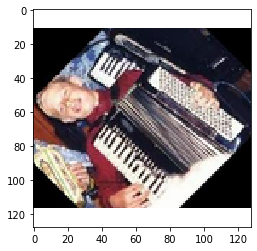

In [42]:
#show image
plot_image(x_train_all[15])

In [43]:
processed_y = convertLabelsToNumbers(y_train_all)
salidasCategoricas = to_categorical(processed_y)

print(len(salidasCategoricas[1]))

classesImageGenerator = np.unique(salidasCategoricas)
nClassesImageGenerator = len(salidasCategoricas[1])
print(nClassesImageGenerator)

102
102


Se debe ejecutar todas las celdas antes de esta

# Aumentar el set de datos con DataGenerator

### Creando el modelo generador de datos

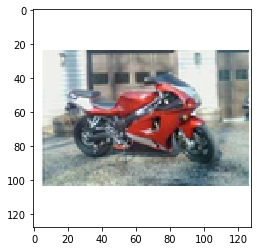

<class 'numpy.ndarray'>
<class 'list'>


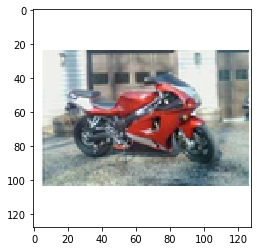

In [72]:
plot_image(X_train_generator[0])
print(type(X_train_generator))
listadoImagenes = list(X_train_generator)

#hago las conversiones a cada imagen
#añado las conversiones a la lista con append
#convierto la lista nuevamente a numpy para entregarla a los modelos

print(type(listadoImagenes))
numpyImagenes = array(listadoImagenes)
plot_image(numpyImagenes[0])

In [61]:
X_train_generator, X_test_generator, y_train_generator, y_test_generator = train_test_split(
        x_train_all, salidasCategoricas, 
        test_size=0.33, 
        random_state=52)

print(X_train_generator.shape, y_train_generator.shape)
print(X_test_generator.shape, y_test_generator.shape)

(6127, 128, 128, 3) (6127, 102)
(3018, 128, 128, 3) (3018, 102)


In [0]:
modelImageGenerator = ModeloExterno(nombreModelo="wisrovi-imageGenerator", rutaBase=BASE_FOLDER)

In [30]:
#Aumentamos el dataset para tener mas datos que procesar
datagen = ImageDataGenerator(
    rotation_range=25, # grados de rotacion aleatoria
    width_shift_range=0.2, # fraccion del total (1) para mover la imagen
    height_shift_range=0.2, # fraccion del total (1) para mover la imagen
    shear_range=0.1, # deslizamiento
    zoom_range=0.1, # rango de zoom
    horizontal_flip=True, # girar las imagenes horizontalmente (eje vertical)
    fill_mode='nearest', # como rellenar posibles nuevos pixeles
    channel_shift_range=0.2 # cambios aleatorios en los canales de la imagen
)

convnet_augmentation = models.Sequential()
convnet_augmentation.add(Conv2D(32,(3,3),input_shape=(128,128,3),activation='relu', padding='same'))
convnet_augmentation.add(Conv2D(32,(3,3),activation='relu'))
convnet_augmentation.add(MaxPooling2D((2, 2),padding='same'))
convnet_augmentation.add(Dropout(0.5))
convnet_augmentation.add(Conv2D(32,(3,3),activation='relu'))
convnet_augmentation.add(MaxPooling2D((2,2)))
convnet_augmentation.add(Flatten())
convnet_augmentation.add(Dropout(0.25))
convnet_augmentation.add(Dense(32,activation='relu'))
convnet_augmentation.add(Dropout(0.5))
convnet_augmentation.add(Dense(nClassesImageGenerator,activation='softmax'))

convnet_augmentation.compile(optimizer='rmsprop',
               loss='categorical_crossentropy', #para mas de dos clases de clasificación
               metrics=['accuracy'])

convnet_augmentation.summary()

modelImageGenerator.GuardarModelo(convnet_augmentation)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 28800)            

True

### Preparando y entrenando el modelo Generador de datos

2857


Entrenamiento 1
Epoch 1/10
2857/2857 [==============================] - 162s 57ms/step - loss: 3.8225 - acc: 0.1863 - val_loss: 3.2529 - val_acc: 0.2962
Epoch 2/10
2857/2857 [==============================] - 156s 55ms/step - loss: 3.4998 - acc: 0.2475 - val_loss: 3.2193 - val_acc: 0.2777
Epoch 3/10
2857/2857 [==============================] - 155s 54ms/step - loss: 3.4635 - acc: 0.2539 - val_loss: 3.4436 - val_acc: 0.2187
Epoch 4/10
2857/2857 [==============================] - 158s 55ms/step - loss: 3.5118 - acc: 0.2489 - val_loss: 3.5010 - val_acc: 0.2376
Epoch 5/10
2857/2857 [==============================] - 156s 55ms/step - loss: 3.5117 - acc: 0.2496 - val_loss: 3.7206 - val_acc: 0.2127
Epoch 6/10
2857/2857 [==============================] - 156s 55ms/step - loss: 3.5055 - acc: 0.2535 - val_loss: 3.2868 - val_acc: 0.2850

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/10
2857/2857 [==============================] - 155s 54ms/step - 

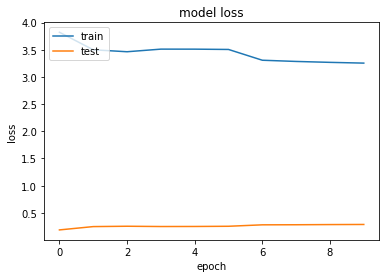

3018/3018 [==============================] - 1s 471us/step
Test loss: 3.463860061328248
Test accuracy: 0.24751491054665417
Pesos Guardados!
***************



Entrenamiento 2
Epoch 1/10
2857/2857 [==============================] - 158s 55ms/step - loss: 3.2428 - acc: 0.2892 - val_loss: 3.4992 - val_acc: 0.2429
Epoch 2/10
2857/2857 [==============================] - 155s 54ms/step - loss: 3.2283 - acc: 0.2901 - val_loss: 3.5021 - val_acc: 0.2419
Epoch 3/10
2857/2857 [==============================] - 158s 55ms/step - loss: 3.2352 - acc: 0.2884 - val_loss: 3.4802 - val_acc: 0.2472
Epoch 4/10
2857/2857 [==============================] - 154s 54ms/step - loss: 3.2382 - acc: 0.2880 - val_loss: 3.5193 - val_acc: 0.2329
Epoch 5/10
2857/2857 [==============================] - 156s 54ms/step - loss: 3.2313 - acc: 0.2872 - val_loss: 3.5052 - val_acc: 0.2399
Epoch 6/10
2857/2857 [==============================] - 155s 54ms/step - loss: 3.2301 - acc: 0.2894 - val_loss: 3.5088 - val_acc: 0.2389
Epo

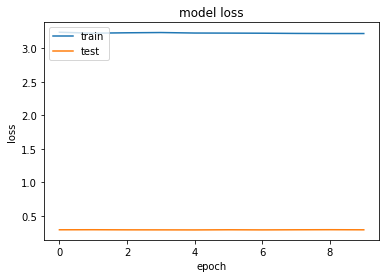

3018/3018 [==============================] - 1s 438us/step
Test loss: 3.5088184364905337
Test accuracy: 0.23724320743200872
***************



Entrenamiento 3
Epoch 1/10
2857/2857 [==============================] - 154s 54ms/step - loss: 3.2247 - acc: 0.2889 - val_loss: 3.4960 - val_acc: 0.2425
Epoch 2/10
2857/2857 [==============================] - 155s 54ms/step - loss: 3.2317 - acc: 0.2883 - val_loss: 3.5136 - val_acc: 0.2353
Epoch 3/10
2857/2857 [==============================] - 155s 54ms/step - loss: 3.2204 - acc: 0.2902 - val_loss: 3.5088 - val_acc: 0.2372
Epoch 4/10
2857/2857 [==============================] - 155s 54ms/step - loss: 3.2175 - acc: 0.2895 - val_loss: 3.5066 - val_acc: 0.2389
Epoch 5/10
2857/2857 [==============================] - 155s 54ms/step - loss: 3.2214 - acc: 0.2892 - val_loss: 3.5132 - val_acc: 0.2359

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 6/10
2857/2857 [==============================] - 154s 54ms/step - l

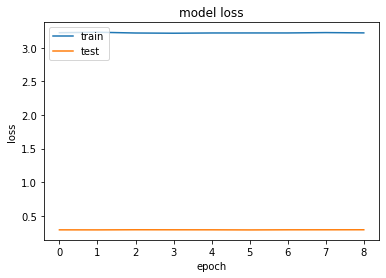

3018/3018 [==============================] - 1s 431us/step
Test loss: 3.5106105663825375
Test accuracy: 0.23691186217024596
***************



Entrenamiento 4
Epoch 1/10
2857/2857 [==============================] - 154s 54ms/step - loss: 3.2207 - acc: 0.2890 - val_loss: 3.5105 - val_acc: 0.2366
Epoch 2/10
2857/2857 [==============================] - 154s 54ms/step - loss: 3.2243 - acc: 0.2895 - val_loss: 3.5102 - val_acc: 0.2366
Epoch 3/10
2857/2857 [==============================] - 155s 54ms/step - loss: 3.2250 - acc: 0.2892 - val_loss: 3.5101 - val_acc: 0.2372
Epoch 4/10
2857/2857 [==============================] - 157s 55ms/step - loss: 3.2195 - acc: 0.2898 - val_loss: 3.5097 - val_acc: 0.2372
Epoch 5/10
2857/2857 [==============================] - 156s 55ms/step - loss: 3.2187 - acc: 0.2900 - val_loss: 3.5095 - val_acc: 0.2372
Epoch 6/10
2751/2857 [===========================>..] - ETA: 5s - loss: 3.2199 - acc: 0.2890Buffered data was truncated after reaching the output size limit

In [31]:
# es necesario especificar el numero de steps cuando se usa un generator (para saber cuando dejar de generar datos en una epoca)
batch_size = 32
num_samples = x_train_all.shape[0] * 10 # multiplicar por 10 el numero de ejemplos
pasos_por_epoca = num_samples//batch_size
iterator_datagen_train = datagen.flow( X_train_generator, y_train_generator,  batch_size=batch_size  )
print(pasos_por_epoca)

numeroEntrenamientos = 30
numeroEpocas = 10
oldModel = None
oldAccuaricy = 0
for i in range(numeroEntrenamientos):     
    print()   
    print()
    print("Entrenamiento " + str(i + 1))

    history_augmentation = convnet_augmentation.fit_generator(
        iterator_datagen_train,
        epochs=numeroEpocas,
        validation_data=(
            X_test_generator, y_test_generator
        ),
        workers=4,
        steps_per_epoch=pasos_por_epoca,
        callbacks=DefineCallback())
        
    plot_history(history_augmentation)
    


    test_eval = convnet_augmentation.evaluate(X_test_generator, y_test_generator, verbose=1)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

    if oldAccuaricy < test_eval[1]:
        oldAccuaricy = test_eval[1]
        modelImageGenerator.GuardarPesosModelo()
        oldModel = convnet_augmentation
    else:
        convnet_augmentation = oldModel

    print("***************")    
    print()

In [0]:
#falta terminar, mirar como con que modelo entrenado puedo generar las imagenes
convnet_augmentation.eva

In [0]:
#falta terminar, mirar como puedo generar las imagenes sin tener que guardarlas en directorio 
#sino guardarlas en los archivos en las fuentes x_train_all y y_train_all
datagen.flow

In [0]:
#falta terminar, buscar que en lugar de guardar en un archivo, guarde el vector
imageGen = datagen.flow(X_test_generator[0], batch_size=1, save_to_dir=args["output"],
	save_prefix="image", save_format="jpg")

for image in imageGen:
	# increment our counter
	total += 1
 
	# if we have reached the specified number of examples, break
	# from the loop
	if total == args["total"]:
		break

# Repartiendo los datos entre Train, test, eval y predic

In [0]:
imagen = 250
#print(processed_y[imagen], y_train_all[imagen])

In [45]:
classes = np.unique(processed_y)
nClasses = len(classes)
print("Numero de clases diferenes:", nClasses)
print()

(X_train, y_train), (X_test, y_test), (X_predic, y_predic) = DividirDatos_Train_Test_Predic(x_train_all, processed_y)

print("Training (66.98%)") 
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print() 
print("Test (22.1%)") 
print("X_test", X_test.shape)
print("y_test", y_test.shape)
print()
print("Predict (10.89%)") 
print("X_predic", X_predic.shape)
print("y_predic", y_predic.shape)

print()
if y_predic.shape[1] == y_test.shape[1] and y_test.shape[1] == y_train.shape[1]:
    print("Distribución correcta")
else:
    print("Fallo en la distribución")

Numero de clases diferenes: 102

Training (66.98%)
X_train (6127, 128, 128, 3)
y_train (6127, 102)

Test (22.1%)
X_test (2022, 128, 128, 3)
y_test (2022, 102)

Predict (10.89%)
X_predic (996, 128, 128, 3)
y_predic (996, 102)

Distribución correcta


In [46]:
#Creamos el Set de Entrenamiento y Validación
#divido los datos de entrenamiento en dos, un 80% para el entrenamiento y otro 20% para validacion
train_X,valid_X,train_label,valid_label = train_test_split(
    X_train, y_train, 
    test_size=0.1, random_state=43)

print("training")
print(train_X.shape)
print(train_label.shape)
print()
print("Valid")
print(valid_X.shape)
print(valid_label.shape)

training
(5514, 128, 128, 3)
(5514, 102)

Valid
(613, 128, 128, 3)
(613, 102)


# Nueva Red Neuronal

## Red Neuronal

In [0]:
modelExtern = ModeloExterno(nombreModelo="wisrovi-nuevoModelo", rutaBase=BASE_FOLDER)

In [51]:
print("********** Modelo *********")

new_model = Sequential()
new_model.add(
    Conv2D(32,
           kernel_size=(3, 3),
           activation='relu',
           padding='same',
           input_shape=(128,128,3)
           )
    )
new_model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'  ) )
new_model.add(MaxPooling2D((2, 2),padding='same'))
new_model.add(Dropout(0.5))

new_model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'  ) )
new_model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'  ) )

new_model.add(Dropout(0.25)) #apagar un 25% de manera aleatoria para reducir la cantidad de parametros
new_model.add(Dense(64, activation='relu'))
new_model.add(Dense(64, activation='relu'))

new_model.add(Dense(64, activation='relu'))
new_model.add(Dropout(0.5)) #apagar un 50% de manera aleatoria para reducir la cantidad de parametros
new_model.add(Flatten()) #para aplanar todas las capas
new_model.add(Dense(nClasses, activation='softmax')) #Genero la capa final con la cantidad de neuronas segun la cantidad de opciones de clasificacion

new_model.summary()

new_model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

modelExtern.GuardarModelo(new_model)

********** Modelo *********
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
dropout_16 (Dropout)      

True

## Entrenar el modelo



Entrenamiento 1
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 10s 2ms/step - loss: 3.8312 - acc: 0.2086 - val_loss: 3.2742 - val_acc: 0.3083
Epoch 2/10
5514/5514 [==============================] - 8s 1ms/step - loss: 2.8909 - acc: 0.3634 - val_loss: 2.8432 - val_acc: 0.3899
Epoch 3/10
5514/5514 [==============================] - 8s 1ms/step - loss: 2.3757 - acc: 0.4628 - val_loss: 2.6251 - val_acc: 0.4502
Epoch 4/10
5514/5514 [==============================] - 8s 1ms/step - loss: 1.6919 - acc: 0.5919 - val_loss: 2.6530 - val_acc: 0.4910
Epoch 5/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.9220 - acc: 0.7550 - val_loss: 3.0457 - val_acc: 0.4894
Epoch 6/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.3841 - acc: 0.8946 - val_loss: 3.5652 - val_acc: 0.4747
Epoch 7/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.1805 - acc: 0.9496 - val_loss: 3.9244 - val_acc: 0.4

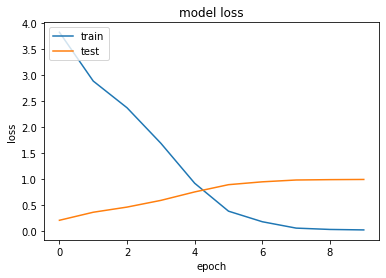

2022/2022 [==============================] - 2s 936us/step
Test loss: 4.374014530879926
Test accuracy: 0.49653808110781406
Pesos Guardados!
***************



Entrenamiento 2
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0204 - acc: 0.9949 - val_loss: 4.8131 - val_acc: 0.4959
Epoch 2/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0187 - acc: 0.9949 - val_loss: 4.8812 - val_acc: 0.4976
Epoch 3/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0125 - acc: 0.9978 - val_loss: 4.9608 - val_acc: 0.4992
Epoch 4/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0131 - acc: 0.9967 - val_loss: 5.0284 - val_acc: 0.4910
Epoch 5/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0123 - acc: 0.9969 - val_loss: 4.9842 - val_acc: 0.5024

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 6/10
5514/5514 [====

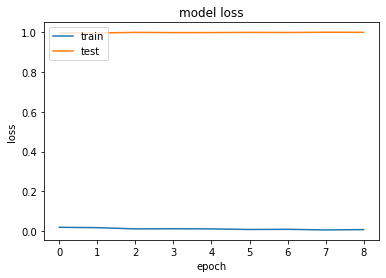

2022/2022 [==============================] - 2s 924us/step
Test loss: 4.7105025042412185
Test accuracy: 0.5
Pesos Guardados!
***************



Entrenamiento 3
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0078 - acc: 0.9982 - val_loss: 5.0500 - val_acc: 0.5008
Epoch 2/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0097 - acc: 0.9980 - val_loss: 5.0515 - val_acc: 0.5008
Epoch 3/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0082 - acc: 0.9989 - val_loss: 5.0543 - val_acc: 0.4992
Epoch 4/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0074 - acc: 0.9982 - val_loss: 5.0547 - val_acc: 0.5008
Epoch 5/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0094 - acc: 0.9980 - val_loss: 5.0583 - val_acc: 0.4992

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 6/10
5514/5514 [===================

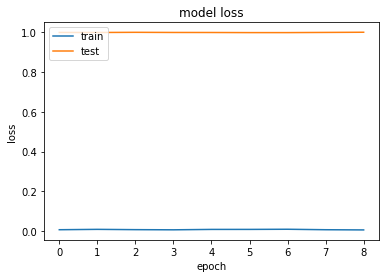

2022/2022 [==============================] - 2s 933us/step
Test loss: 4.720544273610403
Test accuracy: 0.5004945598417408
Pesos Guardados!
***************



Entrenamiento 4
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0090 - acc: 0.9980 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 2/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0079 - acc: 0.9982 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 3/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0082 - acc: 0.9987 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 4/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0075 - acc: 0.9987 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 5/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0096 - acc: 0.9980 - val_loss: 5.0588 - val_acc: 0.4992

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
Epoch 6/10
5514/5514 [======

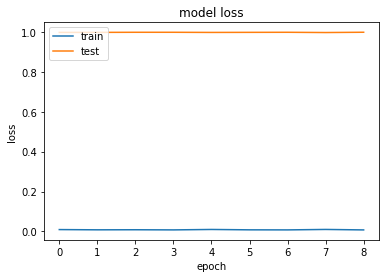

2022/2022 [==============================] - 2s 923us/step
Test loss: 4.72054418824193
Test accuracy: 0.5004945598417408
***************



Entrenamiento 5
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0076 - acc: 0.9985 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 2/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0083 - acc: 0.9984 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 3/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0079 - acc: 0.9985 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 4/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0083 - acc: 0.9980 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 5/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0089 - acc: 0.9984 - val_loss: 5.0588 - val_acc: 0.4992

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.
Epoch 6/10
5514/5514 [========================

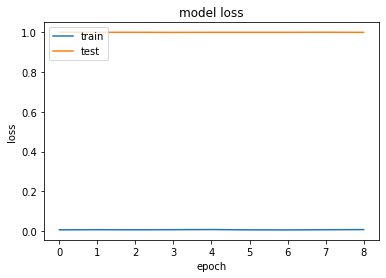

2022/2022 [==============================] - 2s 932us/step
Test loss: 4.720544273138754
Test accuracy: 0.5004945598417408
***************



Entrenamiento 6
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0079 - acc: 0.9984 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 2/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0076 - acc: 0.9985 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 3/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0076 - acc: 0.9987 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 4/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0091 - acc: 0.9976 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 5/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0079 - acc: 0.9982 - val_loss: 5.0588 - val_acc: 0.4992

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000001044244145e-13.
Epoch 6/10
5514/5514 [======================

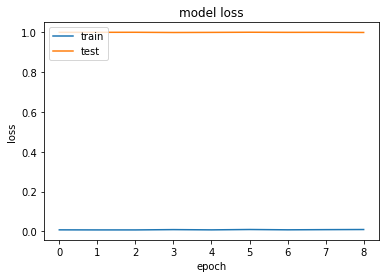

2022/2022 [==============================] - 2s 933us/step
Test loss: 4.720544273138754
Test accuracy: 0.5004945598417408
***************



Entrenamiento 7
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0080 - acc: 0.9984 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 2/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0067 - acc: 0.9982 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 3/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0096 - acc: 0.9976 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 4/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0098 - acc: 0.9978 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 5/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0067 - acc: 0.9989 - val_loss: 5.0588 - val_acc: 0.4992

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000001518582595e-15.
Epoch 6/10
5514/5514 [======================

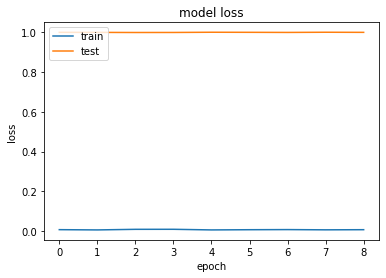

2022/2022 [==============================] - 2s 921us/step
Test loss: 4.720544273138754
Test accuracy: 0.5004945598417408
***************



Entrenamiento 8
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0085 - acc: 0.9984 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 2/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0083 - acc: 0.9978 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 3/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0078 - acc: 0.9984 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 4/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0091 - acc: 0.9976 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 5/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0076 - acc: 0.9980 - val_loss: 5.0588 - val_acc: 0.4992

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000830368326e-17.
Epoch 6/10
5514/5514 [======================

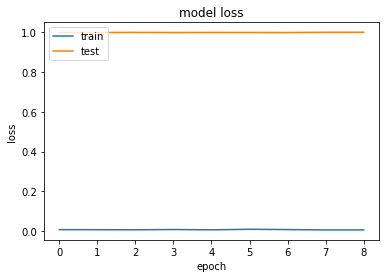

2022/2022 [==============================] - 2s 930us/step
Test loss: 4.720544273138754
Test accuracy: 0.5004945598417408
***************



Entrenamiento 9
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0080 - acc: 0.9987 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 2/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0076 - acc: 0.9987 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 3/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0092 - acc: 0.9980 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 4/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0084 - acc: 0.9982 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 5/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0086 - acc: 0.9984 - val_loss: 5.0588 - val_acc: 0.4992

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.000000045813705e-19.
Epoch 6/10
5514/5514 [=======================

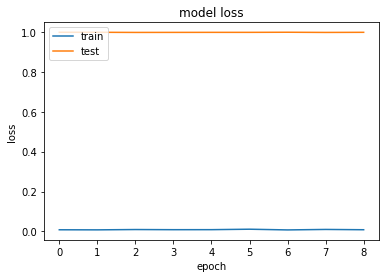

2022/2022 [==============================] - 2s 921us/step
Test loss: 4.720544273138754
Test accuracy: 0.5004945598417408
***************



Entrenamiento 10
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0104 - acc: 0.9966 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 2/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0085 - acc: 0.9984 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 3/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0089 - acc: 0.9984 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 4/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0084 - acc: 0.9984 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 5/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0078 - acc: 0.9987 - val_loss: 5.0588 - val_acc: 0.4992

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000490448793e-21.
Epoch 6/10
5514/5514 [=====================

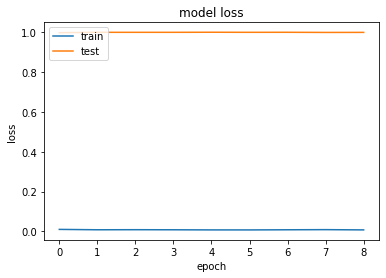

2022/2022 [==============================] - 2s 918us/step
Test loss: 4.720544273138754
Test accuracy: 0.5004945598417408
***************



Entrenamiento 11
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0089 - acc: 0.9982 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 2/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0074 - acc: 0.9987 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 3/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0084 - acc: 0.9987 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 4/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0079 - acc: 0.9985 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 5/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0100 - acc: 0.9973 - val_loss: 5.0588 - val_acc: 0.4992

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000944832675e-23.
Epoch 6/10
5514/5514 [=====================

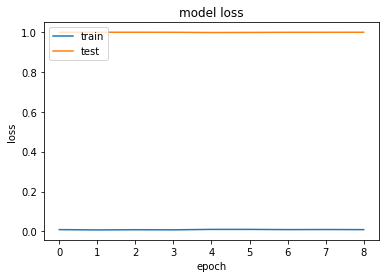

2022/2022 [==============================] - 2s 928us/step
Test loss: 4.720544273138754
Test accuracy: 0.5004945598417408
***************



Entrenamiento 12
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0072 - acc: 0.9984 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 2/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0085 - acc: 0.9982 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 3/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0094 - acc: 0.9984 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 4/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0065 - acc: 0.9991 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 5/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0092 - acc: 0.9980 - val_loss: 5.0588 - val_acc: 0.4992

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000001181490946e-25.
Epoch 6/10
5514/5514 [=====================

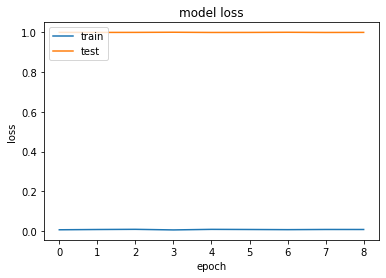

2022/2022 [==============================] - 2s 920us/step
Test loss: 4.720544273138754
Test accuracy: 0.5004945598417408
***************



Entrenamiento 13
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0089 - acc: 0.9980 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 2/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0074 - acc: 0.9984 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 3/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0074 - acc: 0.9984 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 4/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0086 - acc: 0.9976 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 5/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0076 - acc: 0.9989 - val_loss: 5.0588 - val_acc: 0.4992

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.000000142800998e-27.
Epoch 6/10
5514/5514 [======================

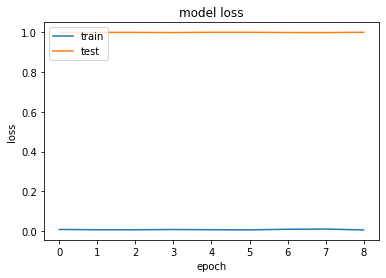

2022/2022 [==============================] - 2s 921us/step
Test loss: 4.720544273138754
Test accuracy: 0.5004945598417408
***************



Entrenamiento 14
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0062 - acc: 0.9991 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 2/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0073 - acc: 0.9989 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 3/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0091 - acc: 0.9976 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 4/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0085 - acc: 0.9985 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 5/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0069 - acc: 0.9989 - val_loss: 5.0588 - val_acc: 0.4992

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000001235416985e-29.
Epoch 6/10
5514/5514 [=====================

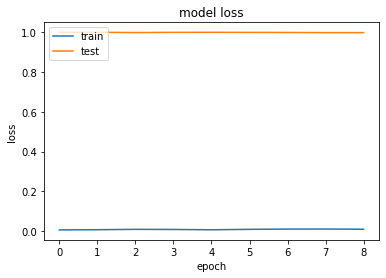

2022/2022 [==============================] - 2s 973us/step
Test loss: 4.720544273138754
Test accuracy: 0.5004945598417408
***************



Entrenamiento 15
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0096 - acc: 0.9984 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 2/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0073 - acc: 0.9984 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 3/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0100 - acc: 0.9982 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 4/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0086 - acc: 0.9982 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 5/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0085 - acc: 0.9984 - val_loss: 5.0588 - val_acc: 0.4992

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.000000191250173e-31.
Epoch 6/10
5514/5514 [======================

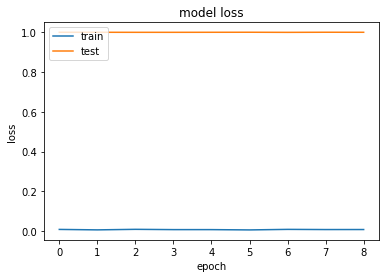

2022/2022 [==============================] - 2s 946us/step
Test loss: 4.720544273138754
Test accuracy: 0.5004945598417408
***************



Entrenamiento 16
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0098 - acc: 0.9982 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 2/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0081 - acc: 0.9985 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 3/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0085 - acc: 0.9982 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 4/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0096 - acc: 0.9975 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 5/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0101 - acc: 0.9976 - val_loss: 5.0588 - val_acc: 0.4992

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000002441474188e-33.
Epoch 6/10
5514/5514 [=====================

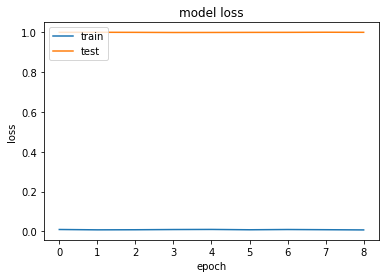

2022/2022 [==============================] - 2s 934us/step
Test loss: 4.720544273138754
Test accuracy: 0.5004945598417408
***************



Entrenamiento 17
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0069 - acc: 0.9989 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 2/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0073 - acc: 0.9984 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 3/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0098 - acc: 0.9982 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 4/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0070 - acc: 0.9995 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 5/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0091 - acc: 0.9978 - val_loss: 5.0588 - val_acc: 0.4992

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000001614954722e-35.
Epoch 6/10
5514/5514 [=====================

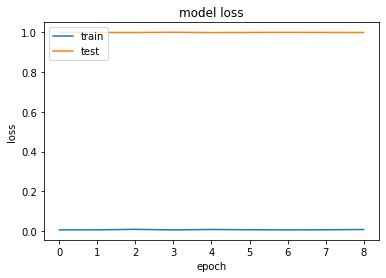

2022/2022 [==============================] - 2s 777us/step
Test loss: 4.720544273138754
Test accuracy: 0.5004945598417408
***************



Entrenamiento 18
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0090 - acc: 0.9980 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 2/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0078 - acc: 0.9985 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 3/10
5514/5514 [==============================] - 8s 2ms/step - loss: 0.0082 - acc: 0.9980 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 4/10
5514/5514 [==============================] - 8s 1ms/step - loss: 0.0085 - acc: 0.9989 - val_loss: 5.0588 - val_acc: 0.4992
Epoch 5/10
5514/5514 [==============================] - 8s 2ms/step - loss: 0.0071 - acc: 0.9989 - val_loss: 5.0588 - val_acc: 0.4992

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000001256222317e-37.
Epoch 6/10
5514/5514 [=====================

KeyboardInterrupt: ignored

In [52]:
#Entreno el modelo
numeroEntrenamientos = 30 #Al final de cada entrenamiento guardo los mejores pesos
numeroEpocas = 10  #ciclos en los cuales evaluo los datos de entrenamiento para hallar los mejores pesos
oldModel = None
oldAccuaricy = 0
for i in range(numeroEntrenamientos):     
    print()   
    print()
    print("Entrenamiento " + str(i + 1))

    history = new_model.fit(
        train_X, train_label, 
        batch_size=64, # cantidad de imágenes que se toman a la vez en memoria
        epochs=numeroEpocas, 
        verbose=1,
        validation_data=(valid_X, valid_label),
        callbacks=DefineCallback()
        )
        
    plot_history(history)
    
    test_eval = new_model.evaluate(X_test, y_test, verbose=1)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

    if oldAccuaricy < test_eval[1]:
        oldAccuaricy = test_eval[1]
        modelExtern.GuardarPesosModelo()
        oldModel = new_model
    else:
        new_model = oldModel
    print("***************")    
    print()

In [53]:
#valido el modelo
test_eval = new_model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

2022/2022 [==============================] - 1s 598us/step
Test loss: 4.720544273138754
Test accuracy: 0.5004945598417408


In [54]:
modelExtern.GuardarPesosModelo()

Pesos Guardados!


True

## Cargar Modelo Red Neuronal Guardado

In [55]:
modeloCargado = modelExtern.CargarModeloGuardado(True)

Lectura del Json del modelo correcta
<class 'str'>
Modelo Cargado!
Pesos Cargados!
Modelo compilado!


In [56]:
#valido el modelo
test_eval = modeloCargado.evaluate(X_predic, y_predic, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

996/996 [==============================] - 2s 2ms/step
Test loss: 5.2087799899549365
Test accuracy: 0.4779116465863454


# Reentrenar un modelo de ImageNet

## Cargar Modelo ImageNet

In [21]:
# VGG16, VGG19, ResNet50, 
#Xception, InceptionV3, InceptionResNetV2, 
#MobileNetV2, DenseNet, RasNet


#https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

from keras.applications import VGG16 
conv_base = VGG16(weights='imagenet',
                 include_top=False, # Si se deben incluir o no las capas de salida originales del modelo
                 input_shape=(128,128,3))

congelarTodoModeloImagenet = False
if congelarTodoModeloImagenet:
  conv_base.trainable = False
else:
  # Freeze the layers except the last 4 layers
  cantidadCapasFinalesDescongelar = 5
  for layer in conv_base.layers[:-cantidadCapasFinalesDescongelar]:
      layer.trainable = False
      pass

  # Check the trainable status of the individual layers
  for layer in conv_base.layers:
      pass
      print(layer, layer.trainable)

conv_base.summary()

58892288/58889256 [==============================] - 2s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7f5ee4f75ef0> False
<keras.layers.convolutional.Conv2D object at 0x7f5ee4f75fd0> False
<keras.layers.convolutional.Conv2D object at 0x7f5ee4f7d080> False
<keras.layers.pooling.MaxPooling2D object at 0x7f5ee4f865f8> False
<keras.layers.convolutional.Conv2D object at 0x7f5ee4f8bc88> False
<keras.layers.convolutional.Conv2D object at 0x7f5ee4f91780> False
<keras.layers.pooling.MaxPooling2D object at 0x7f5ee4f994e0> False
<keras.layers.convolutional.Conv2D object at 0x7f5ee4f9fc50> False
<keras.layers.convolutional.Conv2D object at 0x7f5ee4fa6d30> False
<keras.layers.convolutional.Conv2D object at 0x7f5ee50b8080> False
<keras.layers.pooling.MaxPooling2D object at 0x7f5ee5078048> False
<keras.layers.convolutional.Conv2D object at 0x7f5ee50db8d0> False
<keras.layers.convolutional.Conv2D object at 0x7f5ee50e8198> False
<keras.layers.convolutional.Conv2D object at 0x7f5ee50e2e80> F

## Crear nuestro modelo e incluirle el modelo de imageNet

In [0]:
modeloTrasnferenciaConocimiento = ModeloExterno(nombreModelo="wisrovi-transferLearning", rutaBase=BASE_FOLDER)

In [57]:
pre_trained_model = models.Sequential()
pre_trained_model.add(conv_base)

pre_trained_model.add(Dropout(0.25)) #apagar un 25% de manera aleatoria para reducir la cantidad de parametros


pre_trained_model.add(
    Conv2D(32,
           kernel_size=(3, 3),
           activation='relu',
           padding='same',
           input_shape=(128,128,3)
           )
    )

pre_trained_model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'  ) )

pre_trained_model.add(Dropout(0.25)) #apagar un 25% de manera aleatoria para reducir la cantidad de parametros

#para aplanar todas las capas
#esto se hace debido a que el modelo de VG16 nos da 4 dimensiones de salida, y con esto reducimos las dimensiones a dos: numero datos, numero clases
pre_trained_model.add(Flatten()) 

# conectarlo a nueva parte densa
# Genero la capa final con la cantidad de neuronas segun la cantidad de opciones de clasificacion
pre_trained_model.add(Dense(nClasses, activation='softmax')) 

pre_trained_model.summary()

# compilar el modelo
pre_trained_model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

modeloTrasnferenciaConocimiento.GuardarModelo(pre_trained_model)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
dropout_18 (Dropout)         (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 4, 4, 32)          147488    
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 4, 4, 32)          9248      
_________________________________________________________________
dropout_19 (Dropout)         (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 102)              

True

## Entrenar Modelo Con conocimiento Transferido

Int:  (5514, 128, 128, 3)
Out:  (5514, 102)


Entrenamiento 1
Train on 5514 samples, validate on 613 samples
Epoch 1/15
5514/5514 [==============================] - 10s 2ms/step - loss: 2.1243 - acc: 0.5600 - val_loss: 1.1829 - val_acc: 0.7227
Epoch 2/15
5514/5514 [==============================] - 8s 1ms/step - loss: 0.5904 - acc: 0.8517 - val_loss: 1.0002 - val_acc: 0.7781
Epoch 3/15
5514/5514 [==============================] - 8s 1ms/step - loss: 0.3172 - acc: 0.9148 - val_loss: 1.1441 - val_acc: 0.7716
Epoch 4/15
5514/5514 [==============================] - 8s 1ms/step - loss: 0.2039 - acc: 0.9440 - val_loss: 1.1199 - val_acc: 0.7847
Epoch 5/15
5514/5514 [==============================] - 8s 1ms/step - loss: 0.1723 - acc: 0.9505 - val_loss: 1.4249 - val_acc: 0.7553
Epoch 6/15
5514/5514 [==============================] - 8s 1ms/step - loss: 0.1931 - acc: 0.9577 - val_loss: 0.9978 - val_acc: 0.8042
Epoch 7/15
5514/5514 [==============================] - 8s 1ms/step - loss: 0.1870 - a

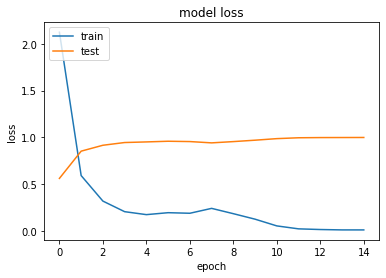

2022/2022 [==============================] - 2s 1ms/step
Test loss: 1.088847250895967
Test accuracy: 0.8239366963992133
Pesos Guardados!
***************



Entrenamiento 2
Train on 5514 samples, validate on 613 samples
Epoch 1/15
3328/5514 [=================>............] - ETA: 2s - loss: 0.0076 - acc: 0.9982

KeyboardInterrupt: ignored

In [58]:
#Entreno el modelo

#Al final de cada entrenamiento guardo los mejores pesos
numeroEntrenamientos = 30

#ciclos en los cuales evaluo los datos de entrenamiento para hallar los mejores pesos
numeroEpocas = 15

#ver datos entrenamiento
print("Int: ", train_X.shape)
print("Out: ", train_label.shape)

oldModel = None
oldAccuaricy = 0
for i in range(numeroEntrenamientos):     
    print()   
    print()
    print("Entrenamiento " + str(i + 1))

    history = pre_trained_model.fit(
        train_X, train_label, 
        batch_size=64, # cantidad de imágenes que se toman a la vez en memoria
        epochs=numeroEpocas,        
        verbose=1,
        validation_data=(valid_X, valid_label),
        callbacks=DefineCallback()
        )
        
    plot_history(history)   

    test_eval = pre_trained_model.evaluate(X_test, y_test, verbose=1)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

    if oldAccuaricy < test_eval[1]:
        oldAccuaricy = test_eval[1]
        modeloTrasnferenciaConocimiento.GuardarPesosModelo()
        oldModel = pre_trained_model
    else:
        pre_trained_model = oldModel
    print("***************")    
    print()

In [59]:
modeloCargadoTransferenciaConocimiento = modeloTrasnferenciaConocimiento.CargarModeloGuardado(True)

Lectura del Json del modelo correcta
<class 'str'>
Modelo Cargado!
Pesos Cargados!
Modelo compilado!


In [60]:
#valido el modelo
test_eval = modeloCargadoTransferenciaConocimiento.evaluate(X_predic, y_predic, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

996/996 [==============================] - 2s 2ms/step
Test loss: 1.1554640588990177
Test accuracy: 0.820281124497992


In [0]:
url = 'https://www.aprendemachinelearning.com/clasificacion-de-imagenes-en-python/'

# Conclusiones

Al usar la transferencia de conocimiento es más facil alcanzar un modelo de clasificacion óptimo para el objetivo propuesto en pocas epocas de reentrenamiento